# Image Preprocessing

In [ ]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *
from fastcore.all import L
from torch import Tensor

In [ ]:
# export
# default_exp preprocess
import SimpleITK as sitk
from fastai.basics import *
from fastai.vision.augment import *
from faimed3d.basics import *
from fastai.torch_core import interp_1d
from tqdm import tqdm

Especially for MRI the pixel values can vary between scanner types. This will lead to a very differnt range of pixel intensities across images in the same batch and the algorithms will have a hard time converging. 
Various techniques exist for rescaling exists of which some are implemented here. 

In [ ]:
@patch
def show_L(l:L, **kwargs): 
    "shows all Tensors in L"
    show_images_3d(torch.stack(tuple(l)), **kwargs)
    
@patch
def apply(l:L, fun):
    "applies a function to each element of L"
    return L(fun(item) for item in l)

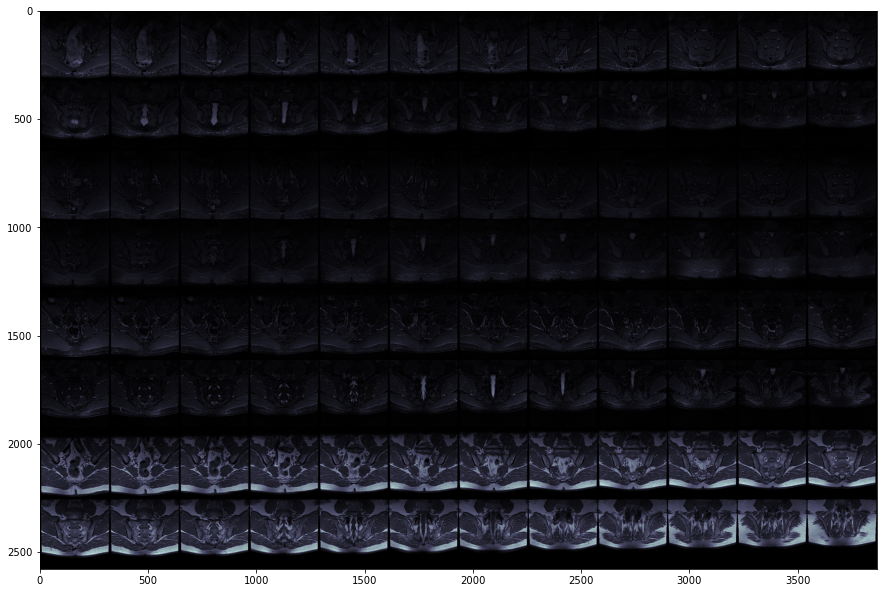

In [ ]:
fns = ["/media/ScaleOut/vahldiek/MRI/SIJ/TRAINING_FINAL/01013/TIRM/", 
       "/media/ScaleOut/vahldiek/MRI/SIJ/TRAINING_FINAL/01014/TIRM/",
       "/media/ScaleOut/vahldiek/MRI/SIJ/TRAINING_FINAL/01015/TIRM/",
       "/media/ScaleOut/vahldiek/MRI/SIJ/TRAINING_FINAL/01015/T1/"]
images = L(TensorDicom3D.create(fn) for fn in fns)
images.show_L(nrow = 12)

## Size correction
if working with data from differnt scanners of even different sequences, pixel spacing can differ. E.g. T2w images are usually in a higher resolution as DWI images, thus the size of each individual pixel is larger in DWI images than in T2W. Normalizing pixel size to a standartized value can help achiving better performance. However, only the H x W Dimension is rescaled, not the D Dimension. 

In [ ]:
# export
@patch
def size_correction(im:(TensorDicom3D, TensorMask3D), new_spacing=1):
    x_sz, y_sz, z_sz  = im.get_spacing()
    m = im.metadata
    rescale_factor = new_spacing/x_sz
    new_sz = (im.size(-3), 
              int(im.size(-2)*rescale_factor), 
              int(im.size(-1)*rescale_factor))
    mode = 'trilinear' if isinstance(im, TensorDicom3D) else 'nearest'
    while im.ndim < 5: im = im.unsqueeze(0)
    im = F.interpolate(im, size = new_sz, mode = mode, align_corners=True).squeeze() #changes memory address, restore_metadata won't work anymore
    im.metadata = m
    im.set_spacing((new_spacing, new_spacing, z_sz))
    return im

In [ ]:
[im.get_spacing() for im in images]

[(0.75, 0.75, 3.3000000817741784),
 (0.75, 0.75, 3.2999999976448877),
 (0.75, 0.75, 3.2999999781836458),
 (0.75, 0.75, 3.2999999781836458)]

In [ ]:
[im.get_spacing() for im in images.apply(size_correction)]

TypeError: 'NoneType' object is not callable

## Pixel rescaling
rescale intercept: 0028|1052  
rescale slope: 0028|1053

In [ ]:
from faimed3d.basics import TensorDicom3D # for compatibility with show_docs

In [ ]:
# export
@patch
def rescale_pixeldata(t:TensorDicom3D):
    m = t.metadata
    if '0028|1053' in m: # if one tag is present, the other should also
        t = t * m['0028|1053'] + m['0028|1052']
        m.pop('0028|1052')
        m.pop('0028|1053')
        t.restore_metadata()
    return t

In [ ]:
im = images[0]
print(im.mean())
# the example MRI images have no rescale slope or intercept
im.metadata['0028|1052'] = 5.
im.metadata['0028|1053'] = 0.5
im = im.rescale_pixeldata()
im.mean()

## Pixel Intensity Normalization
### Mean / Max / Median scaling

In [ ]:
#export 
@patch
def mean_scale(t:TensorDicom3D):
    "Scales pixels by subtracting the mean and dividing by std. 0 pixels are ignored"
    t = t - t.min() # set mit to 0
    mask = t.ne(0.)
    mean, sd = t[mask].mean(), t[mask].std()
    t = (t - mean) / sd
    t.restore_metadata()
    return t

class MeanScale(RandTransform):
    split_idx,order = None, 10
    def __init__(self, p=1., **kwargs):
        super().__init__(p, **kwargs)
        store_attr()
    def encodes(self, x:TensorDicom3D):
        return x.mean_scale()
    def encodes(self, x:TensorMask3D): return x

In [ ]:
images.apply(MeanScale()).show_L(nrow = 12)

In [ ]:
# export
@patch
def median_scale(t:TensorDicom3D):
    "Scales pixels by subtracting the median and dividing by the IQR. 0 pixels are ignored"
    t = t - t.min() # set mit to 0
    mask = t.ne(0.)
    if mask.view(-1).shape[0] >=2 **16: 
        # resize to large tensor for quantile
        # qunatile takes up to size 2**24, but than takes ~1sec 
        mask = F.interpolate(t[mask].view(-1).unsqueeze(0).unsqueeze(0), 2**16)
    median, iqr = mask.median(), mask.quantile(0.75)-mask.quantile(0.25)
    t = (t-median)/iqr
    t.restore_metadata()
    return t

In [ ]:
# export
@patch
def max_scale(t:TensorDicom3D):
    t = (t - t.min()) / (t.max() - t.min())
    t.restore_metadata()
    return t

### Histogram scaling

However, just scaling wiht one mean (or median) and std (or IQR) might not be the optimal solution. 
Histgram scaling might be used for a more evendistribution of pixel values. Differnt functions are provided for histogram scaling: 

#### Method adapted form Jeremy Howard
See the excelent [Kaggle kernel](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) form Jeremy Howard for an explanation

In [ ]:
from torch import Tensor # for compatibility with show_docs

In [ ]:
# export 
@patch
def freqhist_bins(t:(TensorDicom3D,Tensor), n_bins=100):
    '''
    A function to split the range of pixel values into groups, such that each group has around the same number of pixels. 
    taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
    '''
    imsd = t.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(t:(TensorDicom3D,Tensor), brks=None):
    '''
    Scales a tensor using `freqhist_bins` to values between 0 and 1
    taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
    '''
    if t.device.type=='cuda': return t.hist_scaled_pt(brks)
    if brks is None: brks = t.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = t.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    x = tensor(x).reshape(t.shape).clamp(0.,1.)
    return x # will loose meta data in process

@patch
def hist_scaled_pt(t:(TensorDicom3D,Tensor), brks=None):
    "same as fastai fucntion for PILDicom"
    # Pytorch-only version - switch to this if/when interp_1d can be optimized
    if brks is None: brks = t.freqhist_bins()
    brks = brks.to(t.device)
    ys = torch.linspace(0., 1., len(brks)).to(t.device)
    return t.flatten().interp_1d(brks, ys).reshape(t.shape).clamp(0.,1.)

In [ ]:
def f(x): return x.hist_scaled()
images.apply(f).show_L(nrow = 12)

#### Comparison to SimpleITK Adaptive Histogram Equalization
The method from Jeremy Howard is more simple that methods provided in SimpleITK, however it is much faster. 

In [ ]:
im1 = TensorDicom3D(images[0][10:20])

In [ ]:
image = sitk.Cast(im1.as_sitk(), sitk.sitkFloat32)
output = sitk.AdaptiveHistogramEqualization(image, radius=[20]*3, alpha=0.3, beta=0.3) # ~ 30-60 seconds
TensorDicom3D(sitk.GetArrayFromImage(output)).show() 
im1.hist_scaled().show()

#### N4 Bias Field Correction
from official [SimpleITK docs](https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html)
> The N4 bias field correction algorithm is a popular method for correcting low frequency intensity non-uniformity present in MRI image data known as a bias or gain field. The method has also been successfully applied as flat-field correction in microscopy data. This method assumes a simple parametric model and does not require tissue classification.

In [ ]:
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrector.SetMaximumNumberOfIterations([3]*3)
output = corrector.Execute(sitk.Cast(im1.as_sitk(), sitk.sitkFloat32)) # needs float
TensorDicom3D(sitk.GetArrayFromImage(output)).show() #

`faimed3d` provides a wrapper class to apply both N4 Bias Field Correction and Adaptive Histogram Equalization, which basically just simplifies reading the data. 

In [ ]:
# export 
class ImageCorrectionWrapper(object):
    def __init__(self, 
                 n4_max_num_it = 3, 
                 hist_radius = [5,5,5], # radius in format [H x W x D]. Computation time scale ^3 with radius.   
                 hist_alpha  = 0.3, 
                 hist_beta = 0.3, 
                 do_n4 = True, 
                 do_hist = True, 
                 verbose = True):
        store_attr()
        if do_n4: 
            self.corrector = sitk.N4BiasFieldCorrectionImageFilter()

    def __call__(self, orig_file, fn_out=None):
        if isinstance(orig_file, str): 
            if fn_out is None:
                fn_out = self.strip_suffix(fn_in)+'corrected.nii.gz'
            self.convert_string(orig_file, fn_out)
        if isinstance(orig_file, TensorDicom3D):
            if fn_out is None:
                try: fn_out = self.strip_suffix(orig_file.fn)+'corrected.nii.gz'
                except: raise ValueError('Please set a name for the output')
            self._convert(orig_file.as_sitk(), fn_out)
        if self.verbose: 
            print('Coreccted and wrote file to {}'.format(fn_out))
        
    def convert_string(self, fn_in, fn_out):
        im = self.read_image(fn_in)
        self._convert(im, fn_out)

    def _convert(self, im, fn_out):
        if self.do_n4:
            im = self.n4_bias_correction(im)
        if self.do_hist:
            im = self.hist_equal(im)
        sitk.WriteImage(im, fn_out)
    
            
    def n4_bias_correction(self, im):
        self.corrector.SetMaximumNumberOfIterations([self.n4_max_num_it]*3)
        return self.corrector.Execute(im) 
    
    def hist_equal(self, im):
        return sitk.AdaptiveHistogramEqualization(sitk.Cast(im, sitk.sitkInt16), 
                                                  radius=self.hist_radius*3, 
                                                  alpha=self.hist_alpha, 
                                                  beta=self.hist_beta)
    
    def read_image(self, fn):
        "copy of TensorDicom3D.load"
        if isinstance(fn, str): fn = Path(fn)
        if fn.is_dir(): 
            SeriesReader = sitk.ImageSeriesReader()
            dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
            SeriesReader.SetFileNames(dicom_names)
            im = SeriesReader.Execute()
            return sitk.Cast(im, sitk.sitkFloat32)
        elif fn.is_file():
            return sitk.ReadImage(str(fn), outputPixelType=sitk.sitkFloat32)
        else:
            raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))     
            
        
    def strip_suffix(self, fn):
        fn = Path(fn)
        extensions = "".join(fn.suffixes)
        new_fn = str(fn).replace(extensions, '')
        return new_fn+'/' if fn.is_dir() else new_fn

### Piecewise Linear Histogram Matching

[1] N. Laszlo G and J. K. Udupa, “On Standardizing the MR Image Intensity Scale,” Magn. Reson. Med., vol. 42, pp. 1072–1081, 1999.

[2] M. Shah, Y. Xiao, N. Subbanna, S. Francis, D. L. Arnold, D. L. Collins, and T. Arbel, “Evaluating intensity normalization on MRIs of human brain with multiple sclerosis,” Med. Image Anal., vol. 15, no. 2, pp. 267–282, 2011.

Implementation adapted from: https://github.com/jcreinhold/intensity-normalization, ported to pytorch (no use of numpy, works in cuda).

In contrast to `hist_scaled`, the piecewise linear histogram matching need pre-specified values for new scale and landmarks. It should be used to normalize a whole dataset. 

In [ ]:
#export
def get_percentile(t: Tensor, q: float) -> Union[int, float]:
    """   
    Return the ``q``-th percentile of the flattened input tensor's data.
    
    CAUTION:
     * Needs PyTorch >= 1.1.0, as ``torch.kthvalue()`` is used.
     * Values are not interpolated, which corresponds to
       ``numpy.percentile(..., interpolation="nearest")``.
       
    :param t: Input tensor.
    :param q: Percentile to compute, which must be between 0 and 100 inclusive.
    :return: Resulting value (float).
    
    This function is twice as fast as torch.quantile and has no size limitations
    """
    # Note that ``kthvalue()`` works one-based, i.e. the first sorted value
    # indeed corresponds to k=1, not k=0! Use float(q) instead of q directly,
    # so that ``round()`` returns an integer, even if q is a np.float32.
    
    k = 1 + round(.01 * float(q) * (t.numel() - 1))
    result = t.view(-1).kthvalue(k)[0].item()
    
    return result

In [ ]:
# export
def get_landmarks(t: Tensor, percentiles: Tensor)->Tensor:
    """
    Returns the input's landmarks.
       
    :param t (torch.Tensor): Input tensor.
    :param percentiles (torch.Tensor): Peraentiles to calculate landmarks for.
    :return: Resulting landmarks (torch.tensor).
    """
    return tensor([get_percentile(t, perc.item()) for perc in percentiles])

In [ ]:
# export
def find_standard_scale(inputs, i_min=1, i_max=99, i_s_min=1, i_s_max=100, l_percentile=10, u_percentile=90, step=10):
    """
    determine the standard scale for the set of images
    Args:
        inputs (list or L): set of TensorDicom3D objects which are to be normalized
        i_min (float): minimum percentile to consider in the images
        i_max (float): maximum percentile to consider in the images
        i_s_min (float): minimum percentile on the standard scale
        i_s_max (float): maximum percentile on the standard scale
        l_percentile (int): middle percentile lower bound (e.g., for deciles 10)
        u_percentile (int): middle percentile upper bound (e.g., for deciles 90)
        step (int): step for middle percentiles (e.g., for deciles 10)
    Returns:
        standard_scale (np.ndarray): average landmark intensity for images
        percs (np.ndarray): array of all percentiles used
    """
    percs = torch.cat([torch.tensor([i_min]), 
                       torch.arange(l_percentile, u_percentile+1, step), 
                       torch.tensor([i_max])], dim=0)
    standard_scale = torch.zeros(len(percs))
    
    for input_image in inputs:
        mask_data = input_image > input_image.mean()
        masked = input_image[mask_data > 0]
        landmarks = get_landmarks(masked, percs)
        min_p = get_percentile(masked, i_min)
        max_p = get_percentile(masked, i_max)
        new_landmarks = landmarks.interp_1d(torch.FloatTensor([i_s_min, i_s_max]), 
                                            torch.FloatTensor([min_p, max_p]))
        standard_scale += new_landmarks
    standard_scale = standard_scale / len(inputs)
    return standard_scale, percs

In [ ]:
#export
@patch
def piecewise_hist(image:Tensor, landmark_percs, standard_scale)->Tensor:
    """
    do the Nyul and Udupa histogram normalization routine with a given set of learned landmarks
    Args:
        input_image (TensorDicom3D): image on which to find landmarks
        landmark_percs (torch.tensor): corresponding landmark points of standard scale
        standard_scale (torch.tensor): landmarks on the standard scale
    Returns:
        normalized (TensorDicom3D): normalized image
    """
    mask_data = image > image.mean()
    masked = image[mask_data > 0]
    landmarks = get_landmarks(masked, landmark_percs)    
    if landmarks.device != image.device: landmarks = landmarks.to(image.device)
    if standard_scale.device != image.device: standard_scale = standard_scale.to(image.device)
    return image.flatten().interp_1d(landmarks, standard_scale).reshape(image.shape)

class PiecewiseHistScaling(RandTransform):
    split_idx,order = None, 10
    def __init__(self, landmark_percs=None, standard_scale=None, p=1., **kwargs):
        super().__init__(p, **kwargs)
        if landmark_percs is None or standard_scale is None:
            raise ValueError('Landmark parcs and standard scale nned to be provided.'
                             'You can run `standard_scale_from_filelist` or `standard_scale_from_dls` '
                             'To get an estiamtion of the values. Alternatively you can use the '
                             '`PiecewiseHistNormalizationCallback` which will automatically calulated '
                             'the needed values before the first epoch.')
        store_attr()

    def encodes(self, x:TensorDicom3D):
        x = x.piecewise_hist(self.landmark_percs, self.standard_scale)
        return (x - x.mean()) / x.std()

    def encodes(self, x:TensorMask3D): return x


In [ ]:
standard_scale, percs = find_standard_scale(images)
standard_scale, percs

In [ ]:
images.apply(PiecewiseHistScaling(landmark_percs=percs, 
                                  standard_scale=standard_scale)).show_L(nrow = 12)

In [ ]:
# export
def standard_scale_from_filelist(fns:(list, pd.Series)):
    scales = []
    for fn in tqdm(fns):
        x = TensorDicom3D.create(fn)
        scale, percs = find_standard_scale(x)
        scales.append(scale)
    return torch.stack(scales).mean(0), percs

In [ ]:
from fastai.data.core import DataLoaders # for compatibility with show_docs

In [ ]:
#export
@patch
def standard_scale_from_dls(dls:DataLoaders):
    "calculates standard scale from images in a dataloader"
    scales = [] 
    for i, pair in tqdm(enumerate(dls.train_ds)):
        x, _ = pair
        scale, percs = find_standard_scale(x)
        scales.append(scale)
    return torch.stack(scales).mean(0), percs    

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_transforms.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_layers.ipynb.
Converted 06_learner.ipynb.
Converted 06a_models.alexnet.ipynb.
Converted 06b_models.resnet.ipynb.
Converted 06c_models.densenet.ipynb.
Converted 06d_models.unet.ipynb.
Converted 06e_models.deeplabv3.ipynb.
Converted 06f_models.losses.ipynb.
Converted 07_callback.ipynb.
Converted 99_tools.ipynb.
Converted index.ipynb.
